# Intro to Deep Learning with Keras

This tutorial will take you through the basic steps of using a pre-trained model to classify images, then modifying it for another classification task.

To do this, we'll use Keras, and the Oxford [VGG 16 layer model](http://www.robots.ox.ac.uk/~vgg/research/very_deep/).

# Prerequisites

Before we do anything with a network, the first step is to get images in a format we can work with. As a CNN library, Keras itself includes some image processing featues. First, we'll load matplotlib and Keras. *This is a good test to make sure your virtualenv is working too*

### Using Notebooks

If you're unfamiliar with notebooks, you contents of cells. Hit Shift+Enter and the code in a cell will be evaulated and the result printed below. You can add a new cell beneath the current cell by clicking the plus button on the toolbar above.

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg16
from keras import backend as K
from keras.layers import Input
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

/Users/mat/Documents/Keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


Before we can do anything, we need to be able to load images from disk. The code below reads an image and prints it out. Modify the cell to save the result in `image`. Display the image again by adding another line to the cell that evaluates the variable.

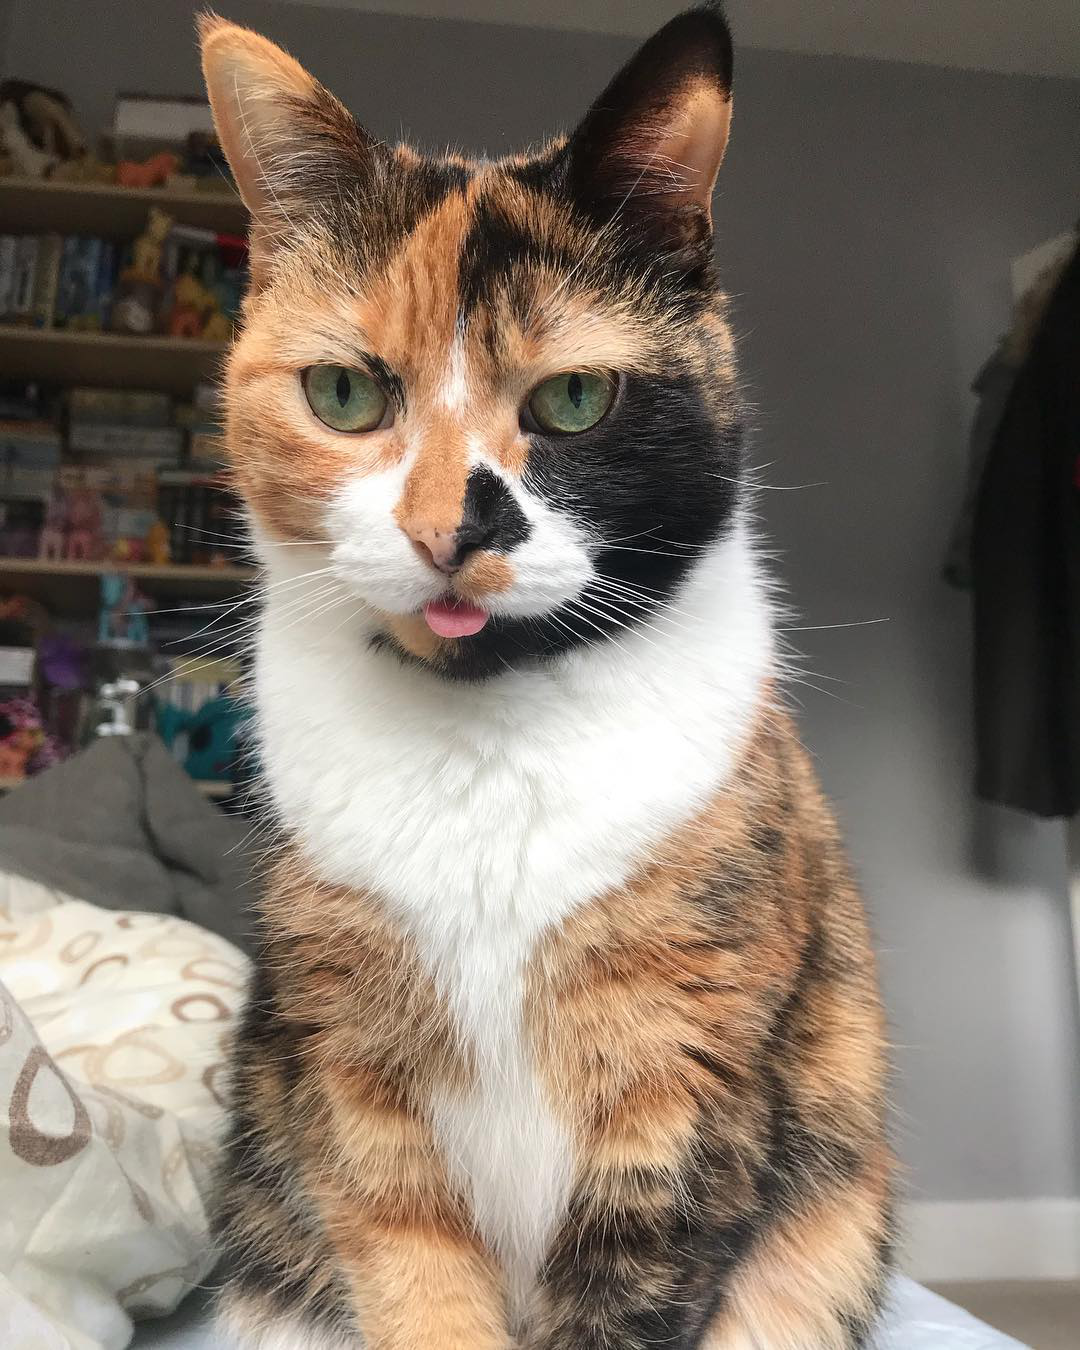

In [10]:
potato = "../images/potato.jpg"
load_img(potato)

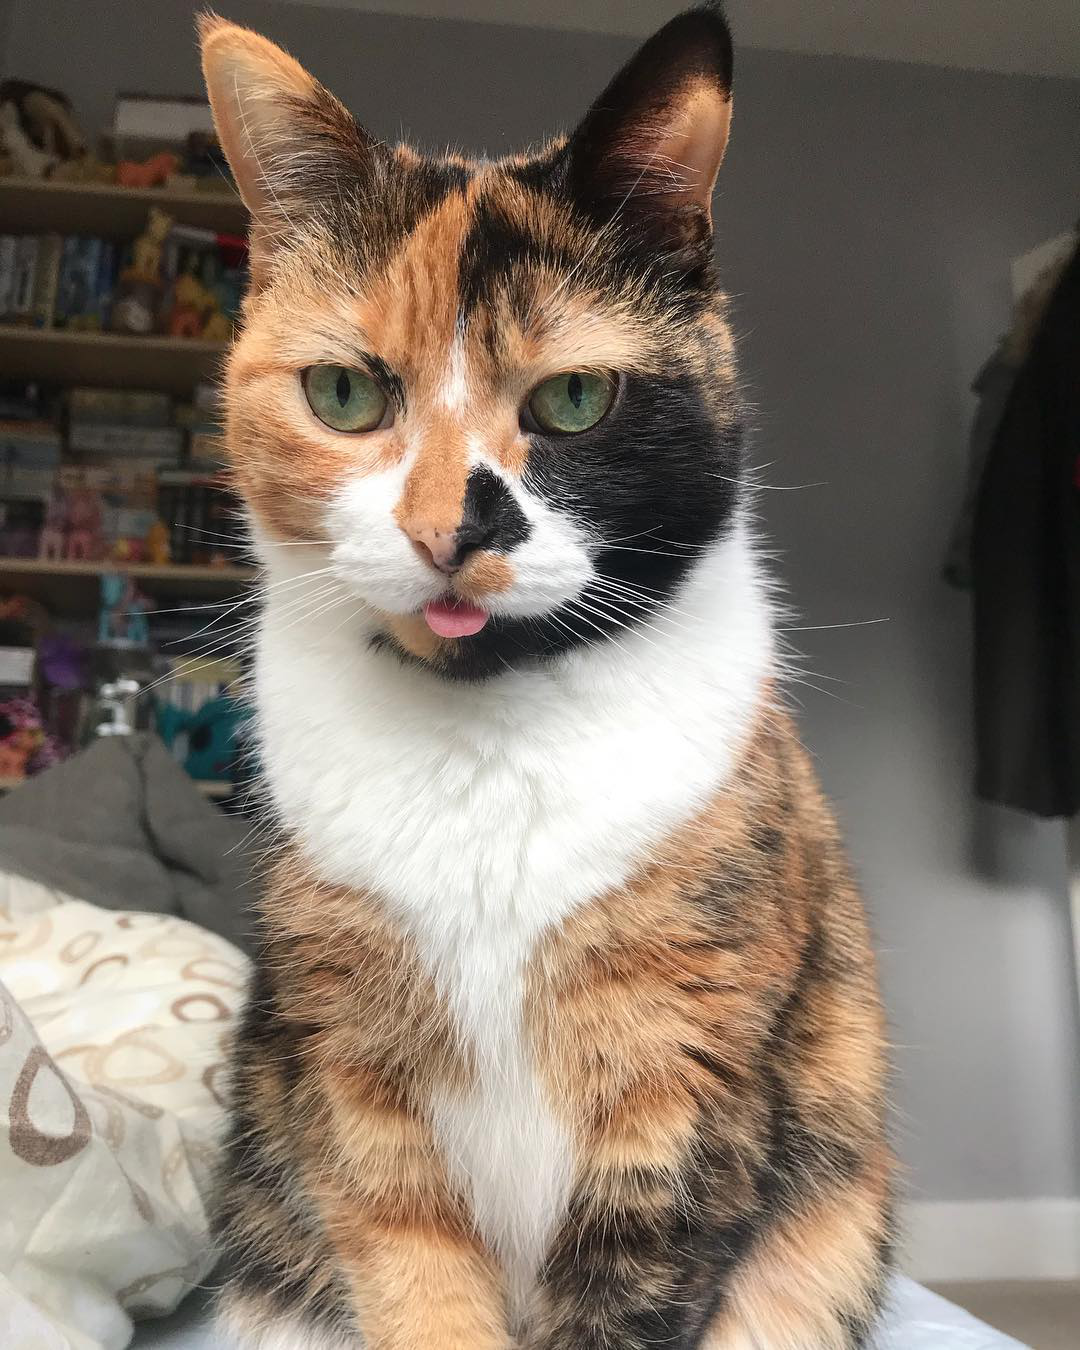

In [11]:
image = load_img("../images/potato.jpg")
image

This is a picture of my cat Potato. In this example we're going to pretend firstly that we want to classify an image to determine if it containts a cat or not.

In the previous workshop, we worked on *feature selection*. We changed our problem slightly, so that we were classifying the type of iris not based on an image, but some manually extracted data. We saw that we could get better results by choosing better features.

In image classification, we assume that we don't have any extra human help when we get an image that needs to be classified; we just get a dump of raw pixels. For a long time computer vision relied on careful engineering of filters to extract features from the raw image (for example [Harr wavelets](https://docs.opencv.org/3.3.0/d7/d8b/tutorial_py_face_detection.html).

In this perspective, we two functions on an input: $\mathit{result} = \mathit{classify}(\mathit{features}(\mathit{input}))$. We write the $\mathit{features}$ function and train a classifier on the feature values.

Deep learning looks at the problem in a different way; what if we got a computer to *learn what features it should use to classify images?* Neural networks have been around for a while, but relatively recent advances in GPU technology (and price) have allowed larger networks to be built. Instead, we have one function, and we learn that function by setting weights in a network. 


# Networks

Neural networks learn a function by setting weights in a network. The network is composed of layers, which consist of neurons. A neuron has one or more inputs, and one output. A neuron produces an ouptut by (usually) summing each input multiplied by an input-specific weight. This sum can be directly output, or piped through a function. For example, the output can be constrained to the range $(-1,1)$ using a sigmoid function.

Generally, a neuron is $\mathit{output} = \mathit{activation}(\sum_i^n i * w_i)$ for $n$ inputs.

There are two intuitions here:

1. The simplest neural network has one neuron. It is equivalent to linear regression if there is no function on its output, or logistic regression if a sigmoid function is used.

For example, for two inputs and one output $y = f(x_1,x_2)$.

2. Every neuron in the network is modelling regression of its inputs against an output (in very broad terms).

Large networks can represent a number of possible functions; changing a weight changes the function the network computes.

So far, we've discussed neurons and hinted that large networks are possible. There's one missing piece. "Deep" networks are so-called because the inputs and outputs are separated by multiple layers of "hidden" neurons. Ignoring more complicated architectures, deep networks are comprised of several stages, the first taking input from the image, then subsequent stages taking input from the previous, until the final output is a prediction for the input.

# VGGnet

VGGnet is a network designed for the 2014 ImageNet Challenge by [Simonyan and Zisserman](https://arxiv.org/abs/1409.1556). The objective of the ImageNet Challenge is to predict the content of an image from the ImageNet database, having trained a classifier on another part of it (the same idea as Kaggle).

VGGnet is available for use and is comprised of two pieces. The first is the network: the number of neurons, and their connectivity with other neurons, and the activation functions for each. VGGnet is grouped into "layers", each of which having the same activation function. The second component is the weights: these are computed using stochastic gradient descent, or (as in our case) we can use the weights someone else computed for us.

# Convolutions

Choosing to use a neural network means we have to solve the problem of connecting it to the inputs. One solution to this is to connect every pixel to every neuron in the input layer. The problem with this [approach is the number of weights needed](http://cs231n.github.io/convolutional-networks/). It also ignores the spatial connection of parts of the image.

Instead of trying to make predictions on the entire image, convolutional networks operate differently. The intuition is that, as above, the computation is better spent trying to learn filters, then predicting the response from those, than it is processing the raw image.

A convolutional network relies on reuse of weights on multiple parts of the image. This is achieved by sliding a small grid (e.g. 3x3) across the input, supplying these to a neuron, and recording the output. This allows the network to summarise localised parts of the image.

CNNs use "layers" to describe the topology. These describe not the neurons themselves, but the size of the output produced by each stage of the network. They are measured in 3 dimensions (X,Y, depth). Each layer has a depth. The input image has 3 colour channels so has a depth of 3 (or 1 if it's converted to greyscale).

Beyond the input image, more than one filter can be learned at a time. A layer that takes a filter's output as input takes each value of each filter before it at each (X,Y) co-ordinate. To cut down on size, "pooling" layers downsample the image using a summary function (e.g. average or max value) of more than one input (X,Y value).

This is hard to describe by text, but fortunately Andrej Karpathy's [description of CNNs has some great diagrams](http://cs231n.github.io/convolutional-networks/).

The intuition here is that by convolving the image, then convolving results from features, later layers in the network compose simpler features extracted by earlier filters in earlier layers.

# The first layer

An image is just an array of pixels, each of which has three values (RGB). We can convert our image into a `numpy` array. 

In [12]:
image_matrix = img_to_array(image)
# print the size of the image matrix here. How many pixels are there? What does the 3 mean?
# How would you get the blue intensity for the image at (500,500)?

In [13]:
image_matrix[(500,500,2)] #2 because the channels are 0:R 1:G 2:B

36.0

To use our image with VGG net, we need to downsample it to fit its input size. Before we do that, let's explore its topology.

As a famous network, Keras comes with VGG's architecture pre-defined, we just need to import it.

In [14]:
help(vgg16)

Help on module keras.applications.vgg16 in keras.applications:

NAME
    keras.applications.vgg16 - VGG16 model for Keras.

DESCRIPTION
    # Reference
    
    - [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

FUNCTIONS
    VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
        Instantiates the VGG16 architecture.
        
        Optionally loads weights pre-trained
        on ImageNet. Note that when using TensorFlow,
        for best performance you should set
        `image_data_format='channels_last'` in your Keras config
        at ~/.keras/keras.json.
        
        The model and the weights are compatible with both
        TensorFlow and Theano. The data format
        convention used by the model is the one
        specified in your Keras config file.
        
        # Arguments
            include_top: whether to include the 3 fully-connected
              

The important thing here is the input size: it has to be 224 by 224 with 3 channels. Let's do that. As we'll do this more then once, here's a function:

In [15]:
img_width = img_height = 224
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

Use the `preprocess_image` function to produce the input ready for VGG. Save it to the variable `img` and print out its shape.

In [16]:
img = preprocess_image(potato)
img.shape

(1, 224, 224, 3)

Using `plt.imshow` try to plot each channel (R,G,B) of the image. Take care to use the right dimensions (hint `:` means "all values") when subsetting with `numpy`.

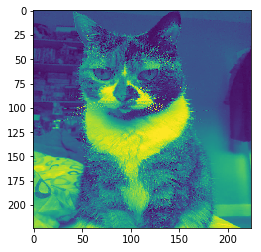

In [17]:
plt.imshow(img[0,:,:,0])

# Getting the VGG model

First we need the *trained* VGG model. We have the topology (which is a fairly simlpe description), but we also need the weights. There are ~$140$ million parameters in VGG, so there's quite a lot to download. On first instantiation of the Keras VGG model it will download the weights automatically. This is about 500MB worth of data so it will take some time.

In [18]:
model = vgg16.VGG16(weights='imagenet', include_top=True)

A Keras model works similarly to other predictive models; once trained, we can supply new data to obtain a prediction. We do this by calling `predict` on the model with the input we want to provide.

As well as `predict` there's also `predict_batch` method for use with larger input sets. We'll just use `predict` for now.

In [19]:
predictions = model.predict(img)
prediction = predictions[0]

The prediction function always returns an array of results, even if it was only given one input to classify, which is why the prediction is immediately unwrapped.

The ImageNet Challenge is run on a total of $1,000$ classes, that is, the aim is to predict which of $1,000$ types of object is in an image.

This means the network has $1,000$ output neurons, one for each class. Each output is a probability.



In the cell below, show that the `prediction` vector contains probabilities, and there are 1000 elements in it.

In [20]:
sum(prediction)

1.0000000152795678

In [21]:
len(prediction)

1000

Now, visualise the results; `prediction` is a vector, and you can use `plt.bar` to plot it. You'll need to define the x-axis.

Text(0.5,0,'class (number)')

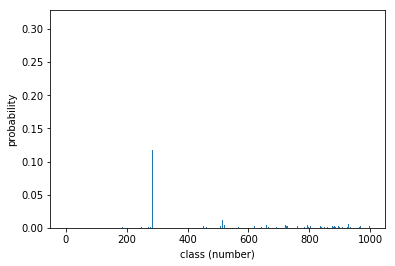

In [22]:
plt.bar(range(len(prediction)),prediction)
plt.ylabel("probability")
plt.xlabel("class (number)")

Given that the network has returned results for each of the $1000$ classes, we usually want the most likely class. Find which element in the `prediction` array has the greatest probability, and print its probability.

In [23]:
prediction.max()

0.3123628

In [24]:
prediction.argmax()

281

We know the most likely class is the 282nd in the array (starting indices at 0). But what class does that correspond to?

In [25]:
from keras.applications.vgg16 import decode_predictions

In [26]:
decode_predictions(predictions)

[[('n02123045', 'tabby', 0.3123628),
  ('n02123159', 'tiger_cat', 0.14321783),
  ('n02124075', 'Egyptian_cat', 0.11799999),
  ('n02113023', 'Pembroke', 0.014613011),
  ('n03124170', 'cowboy_hat', 0.011838604)]]

Perhaps unsurprisingly, there's a $31\%$ chance that my cat is a tabby. More surprisingly there's a small chance she's a cowboy hat.

# Classifying other images

Now, try to use the code above to classify `../images/potato2.jpg`.

What's the most likely class for this image?

In [27]:
img2 = preprocess_image("../images/potato2.jpg")
decode_predictions(model.predict(img2))

[[('n02123394', 'Persian_cat', 0.5734203),
  ('n02123597', 'Siamese_cat', 0.10113113),
  ('n02123045', 'tabby', 0.038828),
  ('n02124075', 'Egyptian_cat', 0.026479935),
  ('n02127052', 'lynx', 0.017209614)]]

Finally, there's a mysterious image in the `images` directory. What does VGGnet think it is?

In [28]:
decode_predictions(model.predict(preprocess_image("../images/mystery.jpg")))

[[('n07697537', 'hotdog', 0.9998751),
  ('n07697313', 'cheeseburger', 4.4649973e-05),
  ('n07684084', 'French_loaf', 2.871024e-05),
  ('n07695742', 'pretzel', 1.5518677e-05),
  ('n02776631', 'bakery', 1.0181494e-05)]]

# Doing something useful

So far, all we've been able to do is reuse a pre-trained network on someone else's classification task. We're limited to being able to classify images in the classes available.

One thing we could do is make meaningful connections from the categories in ImageNet to other things. For example, the `cat` class doesn't exist (in the challenge). Instead, there are several different classes that are all cats. We could simply merge the categories that are similar.

That doesn't solve the problem if our class isn't in the output set. Fortunately, there is a solution: transfer learning.

We're going to use the network *that was trained on a data set unrelated to our problem* and modify it so it produces outputs for a different set of classes. Instead of training a new network, we're going to *add a new network* to the end of the VGG network that predicts, based on the outputs of all but the last layer of VGG16, what the class should be.

The reason this works is because the network has generalised: it's found some good filters that work for many different classes. All we need to do is train a classifier to map the filter results from VGG to our own class probabilities.

In [29]:
new_model = vgg16.VGG16()
new_model.layers.pop()

In [30]:
for layer in new_model.layers:
    layer.trainable = False

In [31]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [32]:
new_model.layers

In [33]:
import keras as K

In [34]:
last = new_model.layers[-1].output
l = K.layers.Dense(2, activation="softmax")(last)

class_model = K.Model(new_model.input, l)

In [35]:
from keras import optimizers

In [36]:
class_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [37]:
class_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Getting some training data

We're going to use someone else's data set to train our new model. ImageNet is the same database that VGG is trained on, and contains images categorised into the same hierarchy of WordNet. In this example, we're going to retrain the model to classify images into one of two categories (instead of the original $1000$).

## Choose your classes

Head to [imagenet](http://www.image-net.org/index) and search for some things you'd like to classify. Find the synset ID for those and save them in the cell below.

In [38]:
class1 = "n02127808"
class2 = "n07697537"

# Downloading images

The code below will query Imagenet for a list of URLs to images in that category. It will then download `count` images and save them into a directory of your choosing.

There's quite a bit of code here - it's not relevant to the exercise, it's designed to filter out as many non-images as possible.

In [39]:
cats = "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02127808"
hotdogs = "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n07697537"

In [40]:
import requests
import os
def fetch_images(synset, directory,count=100):
    try:
        os.mkdir('../' + directory)
    except OSError:
        pass
    url = "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid={}".format(synset)
    r = requests.get(url, stream=True)
    num = 0
    for line in r.iter_lines():
        print(line)
        try:
            download = requests.get(line, allow_redirects=True,timeout=1)
            if download.headers['content-type'] != 'image/jpeg':
                continue
            if download.headers['Content-Length'] == 0:
                continue
            download.raise_for_status()
            open('../{}/{}.jpg'.format(directory,num), 'wb').write(download.content)
            num += 1
        except requests.RequestException:
            pass
        if num == count:
            break

In [ ]:
fetch_images(class1,"cats")

In [ ]:
fetch_images(class2,"hotdogs")

# Learning to Classify

We now have $200$ images, $100$ for each category we chose. We now need to feed them into the Keras model to fit it. We need to provide our data as a numpy array. Ordinarily this would be done in batches, but storing all 200 images in memory (after rescaling them to 224x224) is feasible.

In [42]:
cats = []
for i in os.listdir("../cats"):
    try:
        cats.append(preprocess_image('../cats/{}'.format(i)))
    except OSError:
        pass
cats = np.asarray(cats)[:,0]
hotdogs = []
for i in os.listdir("../hotdogs"):
    try:
        hotdogs.append(preprocess_image('../hotdogs/{}'.format(i)))
    except OSError:
        pass
hotdogs = np.asarray(hotdogs)[:,0]

In [43]:
hotdogs.shape

(100, 224, 224, 3)

# Adding labels

For our classifier training to work, we need labels. Keras will try to minimise the error made on the training set by tuning the weights in the network.

Our labels are going to be "one-hot" vectors. For each example, we'll indicate the desired output value for the network. For the first class this will be `[1,0]`. For the second, it will be `[0,1]`.

In [47]:
labels = np.concatenate([np.tile(np.array([1,0]),(cats.shape[0],1)),np.tile(np.array([0,1]),(hotdogs.shape[0],1))])
training_data = np.concatenate([cats,hotdogs])

In [48]:
labels.shape
training_data.shape

(199, 224, 224, 3)

Now we have everything we need to train the model. This will be done on the CPU so it'll be a lot slower.

# What's happening?

The model is represented as a network of operations performed on input variables. We're using an optimiser to modify the values of the weights in the layer we added last - there are two neurons, each with 4096 inputs and one bias term, so ($4096 * 2 + 2$) total. The non-fixed part of the network is being differentiated with respect to the error, for each weight in turn, and the weight modified based on the gradient for each example.

This is gradient descent, an iterative optimisation technique. An "epoch" consists of showing the network each training example. We're using two here, but GPUs allow far more epochs to be run in far less time. The batch size refers to the number of examples used to calculate the gradient at each step, by shuffling our input, we get an estimate of the gradient and follow it, hoping that the smaller batch size still guides us to good weights.

In [51]:
class_model.fit(training_data,labels,epochs=2,batch_size=16,shuffle=True)

Epoch 1/2
199/199 [==============================] - 75s 375ms/step - loss: 0.0099 - acc: 1.0000
Epoch 2/2
199/199 [==============================] - 75s 379ms/step - loss: 0.0053 - acc: 1.0000


Now, we have a model that's been fine tuned to our problem, but instead of starting from scratch we re-used someone else's model and weights to start.

We can now use the model to classify our own images into the categories we picked earlier:

In [56]:
class_model.predict(img)

array([[0.14766175, 0.85233825]], dtype=float32)

In [57]:
class_model.predict(preprocess_image("../images/mystery.jpg"))

array([[4.3934724e-06, 9.9999559e-01]], dtype=float32)

Depending on your classes, you'll notice a few things:

## Overfitting

We're only using a small number of examples, and a small number of classes, so it'll be quite easy for the network to get $100\%$ accuracy. This doesn't mean the network is a great classifier, it means it's failed to generalise and has instead just memorised the training set perfectly.

Testing the network on different data illustrates this point - probabilities for unseen data will be different. In practice, a test set is needed to validate the network. There are also techniques designed to minimise overfitting (e.g. dropout).

# Summary

* Neural networks are fundamentally "just" linear regression done many times to approximate functions
* Convolutional networks re-use neurons to create filters that later stages of the network use as features to classify inputs
* We can do "surgery" on networks by taking a pre-trained network and cutting off its original output layer, gluing on our own, and adjusting a much smaller number of weights).
* Being able to approximate a large number of functions, a neural network might learn the "wrong" function and overfit instead of learning a generalisable classifier.

# Copyright notice

The image `../images/mystery.jpg` [is in the public domain, from this source image on Wikipedia](https://commons.wikimedia.org/wiki/File:Hot_dog_with_mustard.png).

ImageNet does [not guarantee the images in its database are provided under a permissive license](http://image-net.org/download-faq).

The material in this notebook is heaviliy derived from the [Keras user guide](https://keras.io/getting-started/sequential-model-guide/#training) and Fast AI's [Lesson 1 course material](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb)